In [1]:
import numpy as np
import tqdm 
import osyris
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
import sys

sys.path.append('../my_funcs/')
from pipeline_main import pipeline, dist

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

In [3]:
data = pipeline(snap = 710, run = 'my_core_13restart', sink_id=13)
data.recalc_L(verbose = 1); 

Initialising patch data


100%|██████████| 4165/4165 [00:19<00:00, 212.82it/s]


Converged mean angular momentum vector after 0 iteration(s)


Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 7437.24it/s]
/lustre/hpc/astro/kxm508/codes/dispatch2/experiments/ISM/python/streamers/../my_funcs/pipeline_main.py:176: RuntimeWarning: invalid value encountered in sqrt
  σ_φ = np.sqrt(self.vφ2 - self.vφ**2)


Disk size: 41.3 au


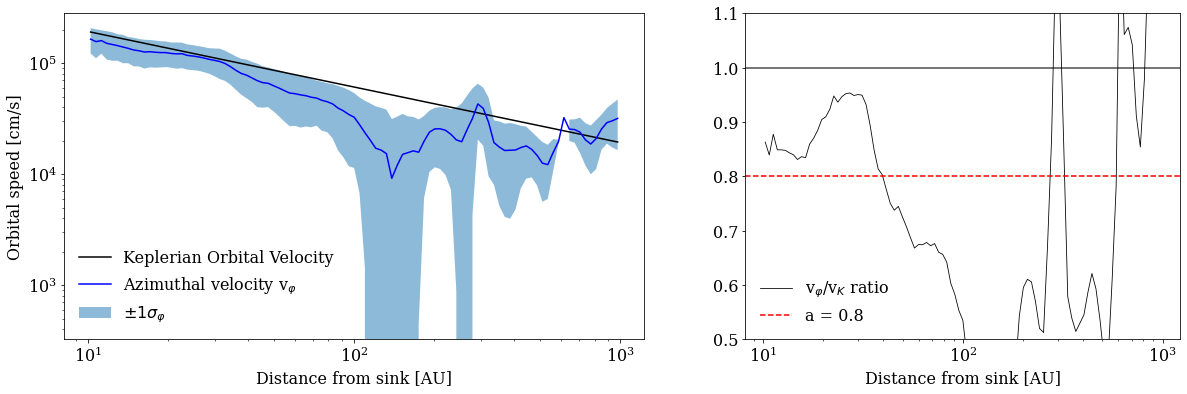

In [4]:
data.calc_disksize()

In [5]:
selection_radius = 1000 / data.au_length
pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

In [6]:
radius = 100; height = 20
radius /= data.au_length; height /= data.au_length

patch_z = []
patch_R = []
patch_vr = []
patch_vz = []
patch_mass = []
patch_vol = []
patch_pressure = []
for p in tqdm.tqdm(sorted_patches):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = (p.cyl_R < radius) & (p.cyl_z < height)
    p.vz = np.sum(p.vrel * data.L[:, None, None, None], axis = 0)
    p.vr = np.sum(p.vrel * p.e_r, axis = 0)
    for lp in leafs: 
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool 
    
    vel_r = p.vr[to_extract].T
    vel_z = p.vz[to_extract].T
    z_coor = p.cyl_z[to_extract].T 
    R_coor = p.cyl_R[to_extract].T
    mass_val = p.m[to_extract].T
    press = p.var('(px**2 + py**2 + pz**2)**0.5')[to_extract].T
    
    patch_z.extend(z_coor.tolist())
    patch_R.extend(R_coor.tolist())
    patch_vr.extend(vel_r.tolist())
    patch_vz.extend(vel_z.tolist())

    patch_pressure.extend(press.tolist())
    patch_mass.extend(mass_val.tolist())
    patch_vol.extend(p.ds[0]**3 * np.ones(len(mass_val)))

patch_vr = np.asarray(patch_vr)
patch_vz = np.asarray(patch_vz)
patch_z = np.asarray(patch_z)    
patch_R = np.asarray(patch_R)    
patch_mass = np.asarray(patch_mass)    
patch_vol = np.asarray(patch_vol) 
patch_pressure = np.asarray(patch_pressure)   

Rz_coor = np.hstack((patch_R[:,None], patch_z[:,None]))

100%|██████████| 1827/1827 [00:01<00:00, 947.84it/s] 


In [7]:
R_grid= np.logspace(np.log10(0.5), np.log10(50), 80) / data.au_length
z_grid = np.logspace(np.log10(0.5), np.log10(20), 30) / data.au_length
R_grid = np.insert(R_grid, 0, 0) 
z_grid = np.insert(z_grid, 0, 0) 

In [8]:
quivergrid_vr = np.linspace(0.5, 48, 30) / data.au_length
quivergrid_vz = np.linspace(0.5, 18, 10) / data.au_length

counts, qbinedgesR, qbinedgesz = np.histogram2d(patch_R, patch_z, bins = (quivergrid_vr, quivergrid_vz))
hist_vr, _, _ = np.histogram2d(patch_R, patch_z, bins = (quivergrid_vr, quivergrid_vz), weights=patch_vr * data.cms_velocity)
hist_vz, _, _ = np.histogram2d(patch_R, patch_z, bins = (quivergrid_vr, quivergrid_vz), weights=patch_vz * data.cms_velocity)

vR_bins = quivergrid_vr[:-1] + 0.5 * np.diff(qbinedgesR)
vz_bins = quivergrid_vz[:-1] + 0.5 * np.diff(qbinedgesz)

In [9]:
hist_mass, binedges_R, binedges_z = np.histogram2d(patch_R, patch_z, bins = (R_grid, z_grid), weights=patch_mass * data.sn.scaling.m)
hist_vol, _, _ = np.histogram2d(patch_R, patch_z, bins = (R_grid, z_grid), weights=patch_vol * data.sn.scaling.l**3)
hist_ρ = hist_mass / hist_vol
R_bins = R_grid[:-1] + 0.5 * np.diff(binedges_R)
z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)

/tmp/ipykernel_2239618/1400636901.py:3: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = hist_mass / hist_vol


In [10]:
R_bins * data.au_length

array([ 0.25      ,  0.51500646,  0.54592016,  0.57868948,  0.61342581,
        0.65024722,  0.68927886,  0.73065341,  0.7745115 ,  0.82100221,
        0.87028356,  0.92252307,  0.9778983 ,  1.03659748,  1.09882012,
        1.16477773,  1.2346945 ,  1.30880809,  1.3873704 ,  1.47064849,
        1.55892541,  1.65250123,  1.75169402,  1.85684094,  1.9682994 ,
        2.08644824,  2.21168907,  2.34444758,  2.48517504,  2.63434978,
        2.79247886,  2.96009977,  3.13778227,  3.32613032,  3.52578411,
        3.7374223 ,  3.96176424,  4.1995725 ,  4.45165541,  4.7188698 ,
        5.00212397,  5.3023807 ,  5.62066061,  5.95804553,  6.31568227,
        6.69478646,  7.0966467 ,  7.52262894,  7.97418113,  8.45283812,
        8.9602269 ,  9.49807213, 10.06820197, 10.67255434, 11.31318347,
       11.99226691, 12.71211291, 13.47516828, 14.2840267 , 15.14143752,
       16.05031516, 17.01374895, 18.03501368, 19.11758068, 20.26512969,
       21.4815613 , 22.77101025, 24.13785947, 25.58675497, 27.12

# Wanted to plot pressure as well - working on it

In [11]:
#hist_pm = np.histogram2d(patch_R, patch_z, bins = (R_grid, z_grid), weights=patch_mass * patch_pressure * data.sn.scaling.m * data.sn.scaling.)

In [12]:
rr_ρ, zz_ρ = np.meshgrid(R_bins, z_bins, indexing='ij')
rr_v, zz_v = np.meshgrid(vR_bins, vz_bins, indexing='ij')

# Try with linspace for the velocities and be carfull with the values above and below the midplane!!

[Text(0, 0.5, 'Height over midplane [AU]'),
 Text(0.5, 0, 'Distance from star  [AU]')]

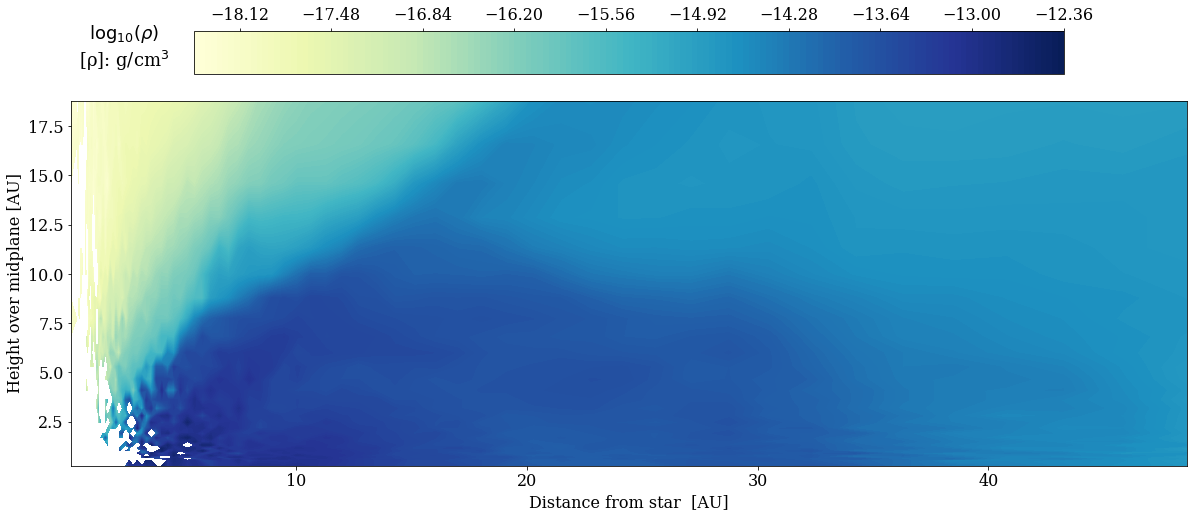

In [13]:
fig, axs = plt.subplots(figsize = (20,8))
cs = axs.contourf(R_bins * data.au_length, z_bins*data.au_length, np.log10(hist_ρ.T), origin = 'lower', levels = 200, cmap = 'YlGnBu')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.1, pad = 0.06, location = 'top');
#axs.xaxis.tick_top()
#axs.xaxis.set_label_position('top') 
cbar.set_label('$\log_{10}(ρ)$\n[ρ]: g/cm$^3$', labelpad = -60, x = -0.08, rotation = 0, fontsize = 18)
axs.set(ylabel = 'Height over midplane [AU]', xlabel = 'Distance from star  [AU]')

In [24]:
ma = np.ma.masked_array(hist_ρ.flatten(), mask=np.isnan(hist_ρ.flatten()))

interpolation = interpolate.griddata(np.hstack((rr_ρ.flatten()[:,None][~ma.mask], zz_ρ.flatten()[:,None][~ma.mask])), ma[~ma.mask], xi = (rr_ρ, zz_ρ), method = 'linear')

In [25]:
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib
arrow_length = np.sqrt((hist_vr/counts)**2 + (hist_vz/counts)**2)
arrow_length[np.isnan(arrow_length)] = 1e-20

/tmp/ipykernel_2239618/3592928542.py:7: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar_vel = fig.colorbar(quiver, cmap=plt.cm.jet, pad = 0.005)


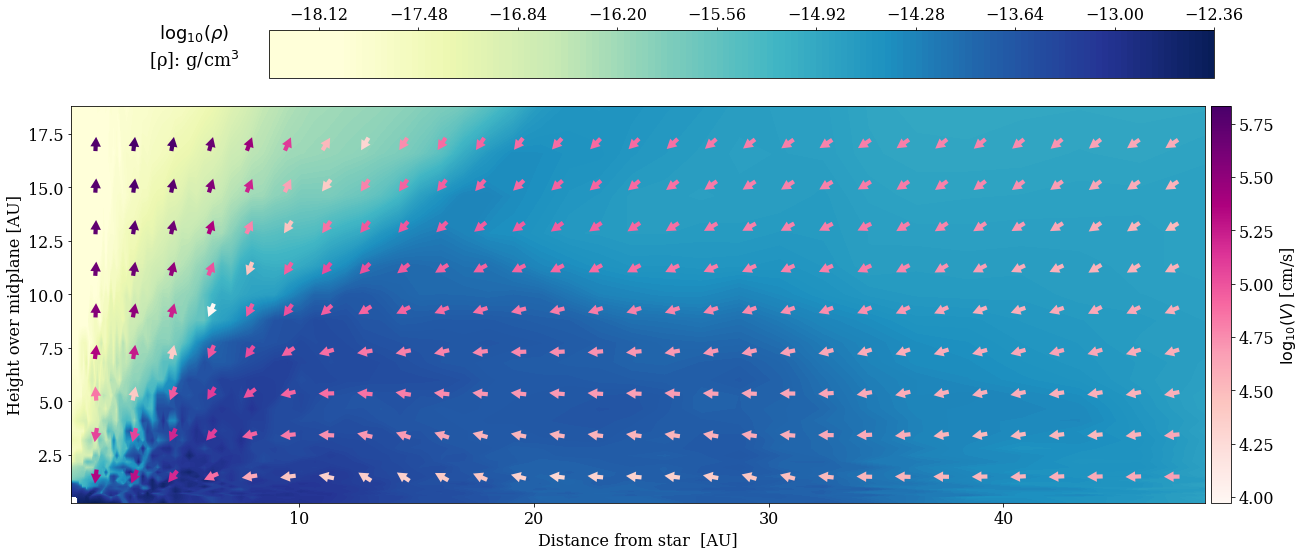

In [26]:
fig, axs = plt.subplots(figsize = (20,8))
cs = axs.contourf(R_bins * data.au_length, z_bins*data.au_length, np.log10(interpolation.T), origin = 'lower', levels = 200, cmap = 'YlGnBu', vmin = -18)
cbar = fig.colorbar(cs, ax = axs, fraction = 0.1, pad = 0.06, location = 'top');

quiver = axs.quiver(rr_v * data.au_length, zz_v*data.au_length, (hist_vr/counts)/arrow_length , (hist_vz/counts)/arrow_length, np.log10(arrow_length), 
                    angles='xy', scale_units='xy', scale=1.5, cmap=cm.RdPu, headwidth = 2.5, headaxislength = 2.3, headlength = 2.3, pivot = 'mid');
cbar_vel = fig.colorbar(quiver, cmap=plt.cm.jet, pad = 0.005)
cbar_vel.set_label('$\log_{10}(V)$ [cm/s]')
cbar.set_label('$\log_{10}(ρ)$\n[ρ]: g/cm$^3$', labelpad = -60, x = -0.08, rotation = 0, fontsize = 18)
axs.set(ylabel = 'Height over midplane [AU]', xlabel = 'Distance from star  [AU]');
plt.tight_layout()

# Now extend so the z-value goes from -h to h

In [ ]:
R_grid= np.logspace(np.log10(1), np.log10(50), 80) / data.au_length
z_grid = np.logspace(np.log10(1), np.log10(20), 30) / data.au_length
R_grid = np.insert(R_grid, 0, 0) 
z_grid = np.insert(z_grid, 0, 0) 
z_grid = np.concatenate((-np.logspace(np.log10(1), np.log10(20), 30)[::-1] / data.au_length , z_grid))

In [ ]:
R_grid * data.au_length

array([ 0.        ,  1.        ,  1.05076585,  1.10410887,  1.16015989,
        1.2190564 ,  1.28094283,  1.34597098,  1.41430034,  1.4860985 ,
        1.56154155,  1.64081453,  1.72411188,  1.81163788,  1.90360722,
        2.00024545,  2.10178961,  2.20848875,  2.32060455,  2.43841201,
        2.56220007,  2.69227233,  2.82894783,  2.97256176,  3.12346639,
        3.28203181,  3.44864694,  3.62372043,  3.80768168,  4.00098187,
        4.20409512,  4.41751958,  4.64177871,  4.87742255,  5.12502904,
        5.3852055 ,  5.65859003,  5.94585315,  6.24769944,  6.56486921,
        6.89814037,  7.24833032,  7.61629797,  8.0029458 ,  8.40922214,
        8.83612345,  9.28469676,  9.75604227, 10.25131604, 10.77173281,
       11.31856897, 11.89316574, 12.4969324 , 13.13134978, 13.79797391,
       14.49843977, 15.23446538, 16.00785595, 16.82050836, 17.67441575,
       18.57167247, 19.5144792 , 20.50514831, 21.54610957, 22.63991613,
       23.7892507 , 24.99693221, 26.2659227 , 27.59933458, 29.00

In [ ]:
quivergrid_vr = np.linspace(0.5, 48, 30) / data.au_length
quivergrid_vz = np.linspace(0.5, 18, 10) / data.au_length
quivergrid_vz = np.concatenate((-np.linspace(0.5, 18, 10)[::-1] / data.au_length, quivergrid_vz))

counts, qbinedgesR, qbinedgesz = np.histogram2d(patch_R, patch_z, bins = (quivergrid_vr, quivergrid_vz))
hist_vr, _, _ = np.histogram2d(patch_R, patch_z, bins = (quivergrid_vr, quivergrid_vz), weights=patch_vr * data.cms_velocity)
hist_vz, _, _ = np.histogram2d(patch_R, patch_z, bins = (quivergrid_vr, quivergrid_vz), weights=patch_vz * data.cms_velocity)

vR_bins = quivergrid_vr[:-1] + 0.5 * np.diff(qbinedgesR)
vz_bins = quivergrid_vz[:-1] + 0.5 * np.diff(qbinedgesz)

arrow_length = np.sqrt((hist_vr/counts)**2 + (hist_vz/counts)**2)
arrow_length[np.isnan(arrow_length)] = 1e-20

In [ ]:
hist_mass, binedges_R, binedges_z = np.histogram2d(patch_R, patch_z, bins = (R_grid, z_grid), weights=patch_mass * data.sn.scaling.m)
hist_vol, _, _ = np.histogram2d(patch_R, patch_z, bins = (R_grid, z_grid), weights=patch_vol * data.sn.scaling.l**3)
hist_ρ = hist_mass / hist_vol
R_bins = R_grid[:-1] + 0.5 * np.diff(binedges_R)
z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)

/tmp/ipykernel_786324/1400636901.py:3: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = hist_mass / hist_vol


In [ ]:
(z_grid * data.au_length)[::2]

array([-20.        , -16.26686225, -13.23054038, -10.76096889,
        -8.75235993,  -7.11867167,  -5.78992257,  -4.70919365,
        -3.83019022,  -3.11525883,  -2.53377432,  -2.06082789,
        -1.67616017,  -1.36329333,  -1.10882524,   0.        ,
         1.10882524,   1.36329333,   1.67616017,   2.06082789,
         2.53377432,   3.11525883,   3.83019022,   4.70919365,
         5.78992257,   7.11867167,   8.75235993,  10.76096889,
        13.23054038,  16.26686225,  20.        ])

In [ ]:
rr_ρ, zz_ρ = np.meshgrid(R_bins, z_bins, indexing='ij')
rr_v, zz_v = np.meshgrid(vR_bins, vz_bins, indexing='ij')

In [ ]:
mask = np.isnan(hist_ρ.flatten())
masked_hist_ρ = np.ma.masked_array(hist_ρ.flatten(), mask=mask)

interpolation = interpolate.griddata(np.hstack((rr_ρ.flatten()[:,None][~mask], zz_ρ.flatten()[:,None][~mask])), masked_hist_ρ[~mask], xi = (rr_ρ, zz_ρ), method = 'linear')

/tmp/ipykernel_786324/2621893259.py:9: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar_vel = fig.colorbar(quiver, cmap=plt.cm.jet, pad = 0.005)


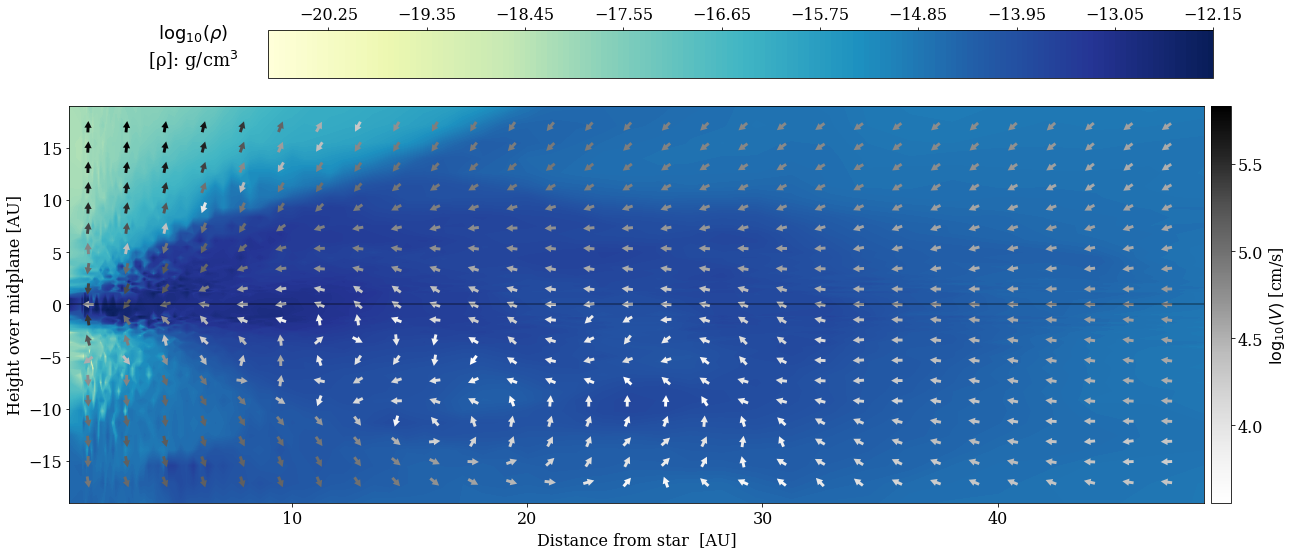

In [ ]:
fig, axs = plt.subplots(figsize = (20,8))


cs = axs.contourf(R_bins * data.au_length, z_bins*data.au_length, np.log10(interpolation.T), origin = 'lower', levels = 200, cmap = 'YlGnBu')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.1, pad = 0.06, location = 'top');

quiver = axs.quiver(rr_v * data.au_length, zz_v*data.au_length, (hist_vr/counts)/arrow_length , (hist_vz/counts)/arrow_length, np.log10(arrow_length), 
                    cmap=cm.Greys, headwidth = 2.5, headaxislength = 2.3, headlength = 2.3, pivot = 'mid', scale = 100);
cbar_vel = fig.colorbar(quiver, cmap=plt.cm.jet, pad = 0.005)
cbar_vel.set_label('$\log_{10}(V)$ [cm/s]')
cbar.set_label('$\log_{10}(ρ)$\n[ρ]: g/cm$^3$', labelpad = -60, x = -0.08, rotation = 0, fontsize = 18)
axs.set(ylabel = 'Height over midplane [AU]', xlabel = 'Distance from star  [AU]');
axs.axhline(0, c='black', alpha = 0.4)
fig.tight_layout()

In [ ]:
pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]



In [ ]:
new_x = np.dot(data.rotation_matrix, np.array([1,0,0])); new_y = np.dot(data.rotation_matrix, np.array([0,1,0]))
new_x

array([ 0.26163186,  0.22205006, -0.93927767])

  0%|          | 0/1 [00:00<?, ?it/s]


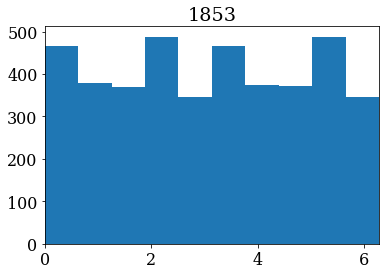

In [ ]:
angle_start = np.array([-data.L[1], data.L[0], 0]); angle_start /= np.linalg.norm(angle_start)

count = 0
for p in tqdm.tqdm(sorted_patches):
    count += 1
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    proj_r = np.sum(p.cyl_r * new_x[:, None, None, None], axis = 0)
    proj_φ = np.sum(p.cyl_r * new_y[:, None, None, None], axis = 0)
    
    angle = np.arctan2(proj_φ, proj_r)
    plt.figure()
    plt.hist(angle.flatten() + np.pi)
    plt.xlim(0, 2*np.pi)
    plt.title(p.id)

    if p.id == 1853: break

In [ ]:
if 2+2 == 4: print('fuck yeah')

fuck yeah


In [ ]:
len

array([0, 1, 0])

  1%|          | 14/1827 [00:00<00:26, 69.03it/s]/tmp/ipykernel_786324/177506961.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
  1%|▏         | 23/1827 [00:00<00:27, 66.33it/s]


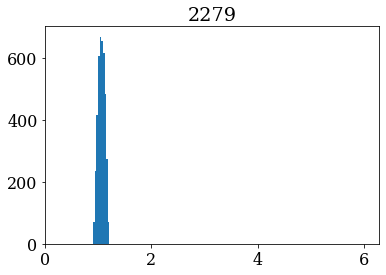

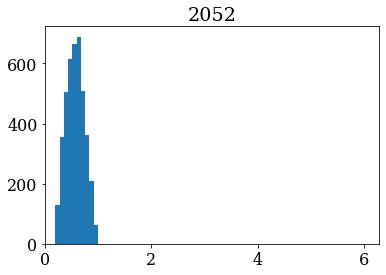

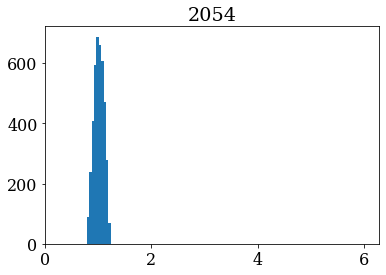

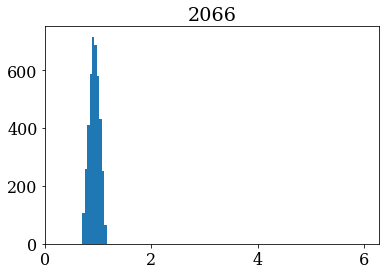

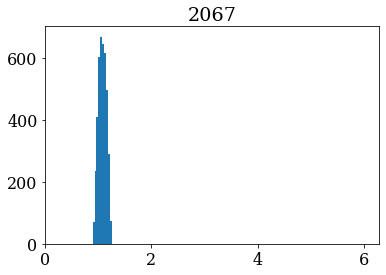

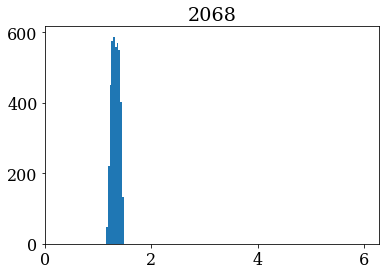

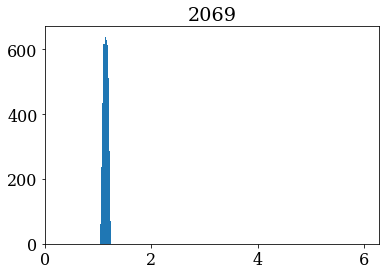

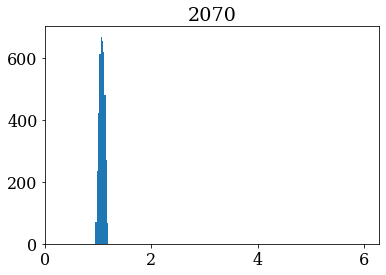

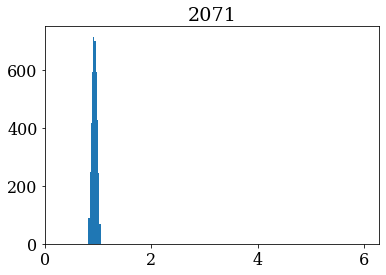

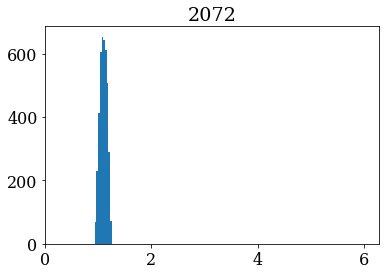

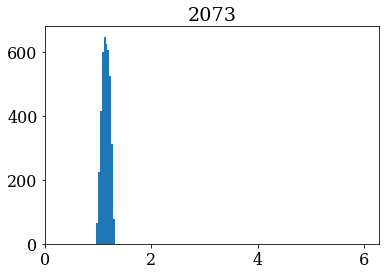

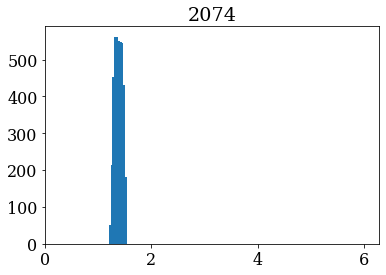

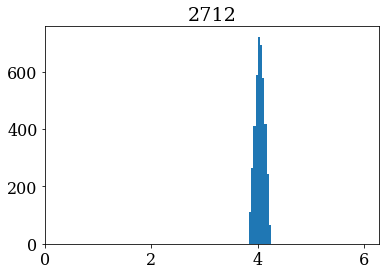

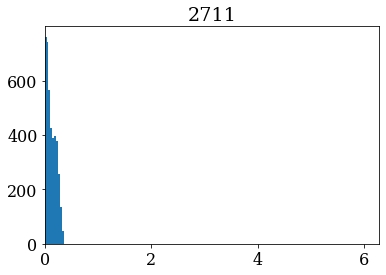

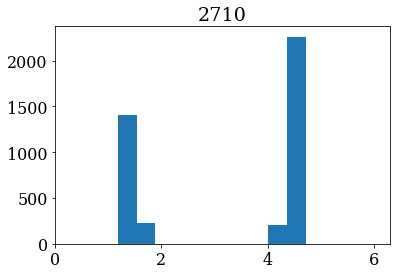

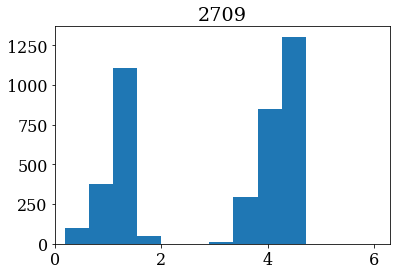

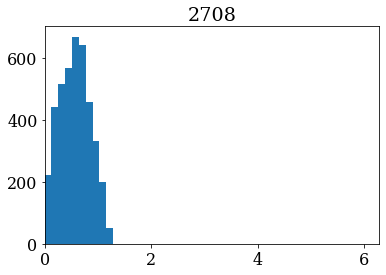

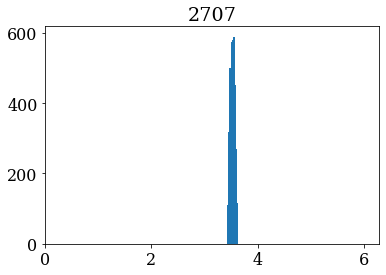

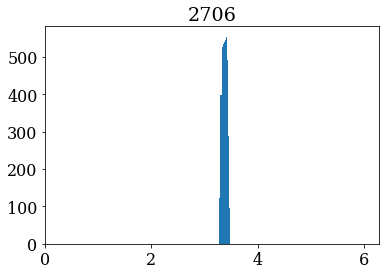

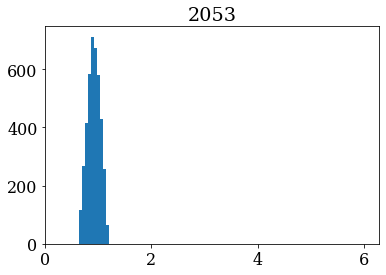

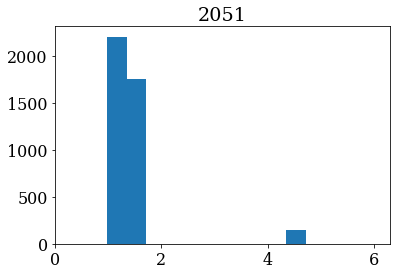

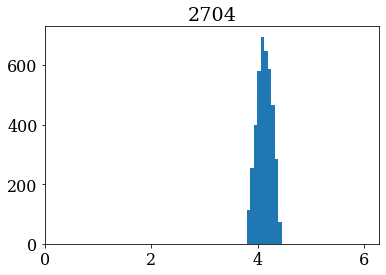

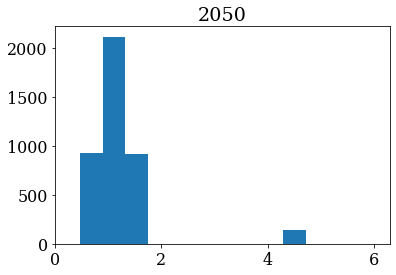

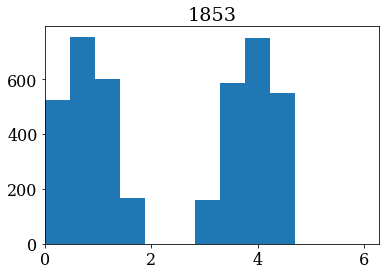

In [ ]:
angle_start = np.array([-data.L[1], data.L[0], 0]); angle_start /= np.linalg.norm(angle_start)

count = 0
for p in tqdm.tqdm(sorted_patches):
    count += 1
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue


    cosine_angle = np.sum(angle_start[:, None, None, None] * p.cyl_r, axis = 0) / p.cyl_R
    angle = np.zeros_like(cosine_angle)
    angle[cosine_angle > 0] = np.arccos(cosine_angle[cosine_angle > 0])
    angle[cosine_angle < 0] = - np.arccos(cosine_angle[cosine_angle < 0])
    plt.figure()
    plt.hist(angle.flatten() + np.pi)
    plt.xlim(0, 2*np.pi)
    plt.title(p.id)
    if p.id == 1853: break

100%|██████████| 1/1 [00:00<00:00, 577.81it/s]


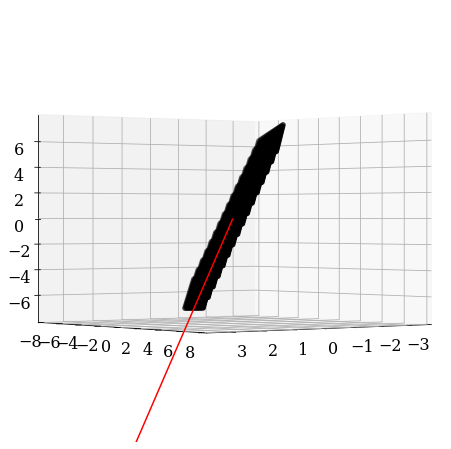

In [ ]:
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(projection='3d')

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < 10 / data.au_length]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]


for p in tqdm.tqdm(sorted_patches):
    ax.scatter(p.cyl_r[0] * data.au_length, p.cyl_r[1]* data.au_length, p.cyl_r[2]* data.au_length, ',', color = 'black')
ax.view_init(elev=0, azim = 52)
ax.quiver(0,0,0, new_x[0], new_x[1], new_x[2], length=30, color = 'red')